In [1]:
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit
from scipy.signal   import savgol_filter

from functools import partial

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"]      = 11

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-11_20_2023-file_1.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [6]:
def wfs_from_rawtree(RawTree, channel):
    return np.array(RawTree[f'chan{channel}/rdigi'].array())

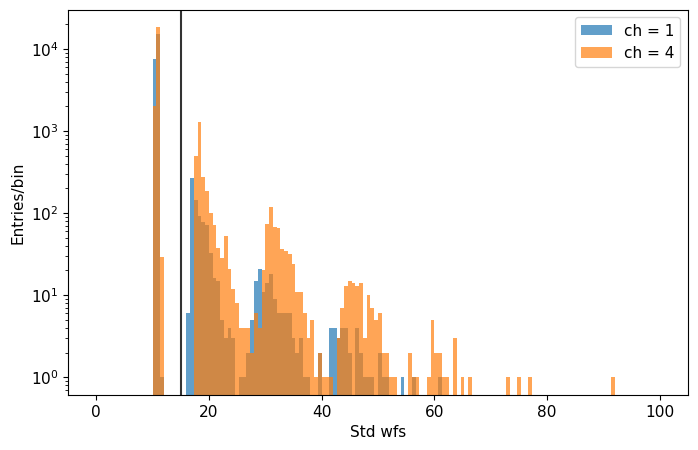

In [7]:
for ch in [1, 4]:
    plt.hist(np.std(np.array(RawTree[f'chan{ch}/rdigi'].array()), axis=1), bins=150, range=(0, 100), log=True, alpha=0.7, label=f'ch = {ch}')
plt.axvline(x=15, color='k', alpha=0.8)
plt.xlabel('Std wfs')
plt.ylabel('Entries/bin')
plt.legend()
plt.show()

## Filter wfs with the std to remove baseline evts

In [8]:
filt_wfs_dict = {ch: np.array([(evt, wf) for evt, wf in enumerate(wfs_from_rawtree(RawTree, ch)) if np.std(wf) > 15])
                 for ch in range(9)}

In [9]:
filt_evts = np.unique(np.concatenate(np.array([filt_wfs_dict[ch].T[0] for ch in range(9)])))

## Subtract baseline

In [10]:
%%time
max_smpl_bsl  = 650
subt_wfs_dict = {ch: np.array([(evt, pf.subtract_baseline(fwf, mode=True, wf_range_bsl=(0, max_smpl_bsl)))
                 for evt, fwf in filt_wfs_dict[ch]])
                 for ch in range(9)}

CPU times: user 3.2 s, sys: 280 ms, total: 3.48 s
Wall time: 4.13 s


In [11]:
for ch in range(9):
    print(len(filt_wfs_dict[ch]), len(subt_wfs_dict[ch]))

4626 4626
908 908
4883 4883
11053 11053
3261 3261
9549 9549
15232 15232
15972 15972
15397 15397


## Sum subt wfs (that have been already filtered)

In [12]:
summed_swfs_dict = {ch: np.sum([wf[1] for wf in subt_wfs_dict[ch]], axis=0)
                    for ch in range(9)}

In [13]:
summed_swfs_dict;

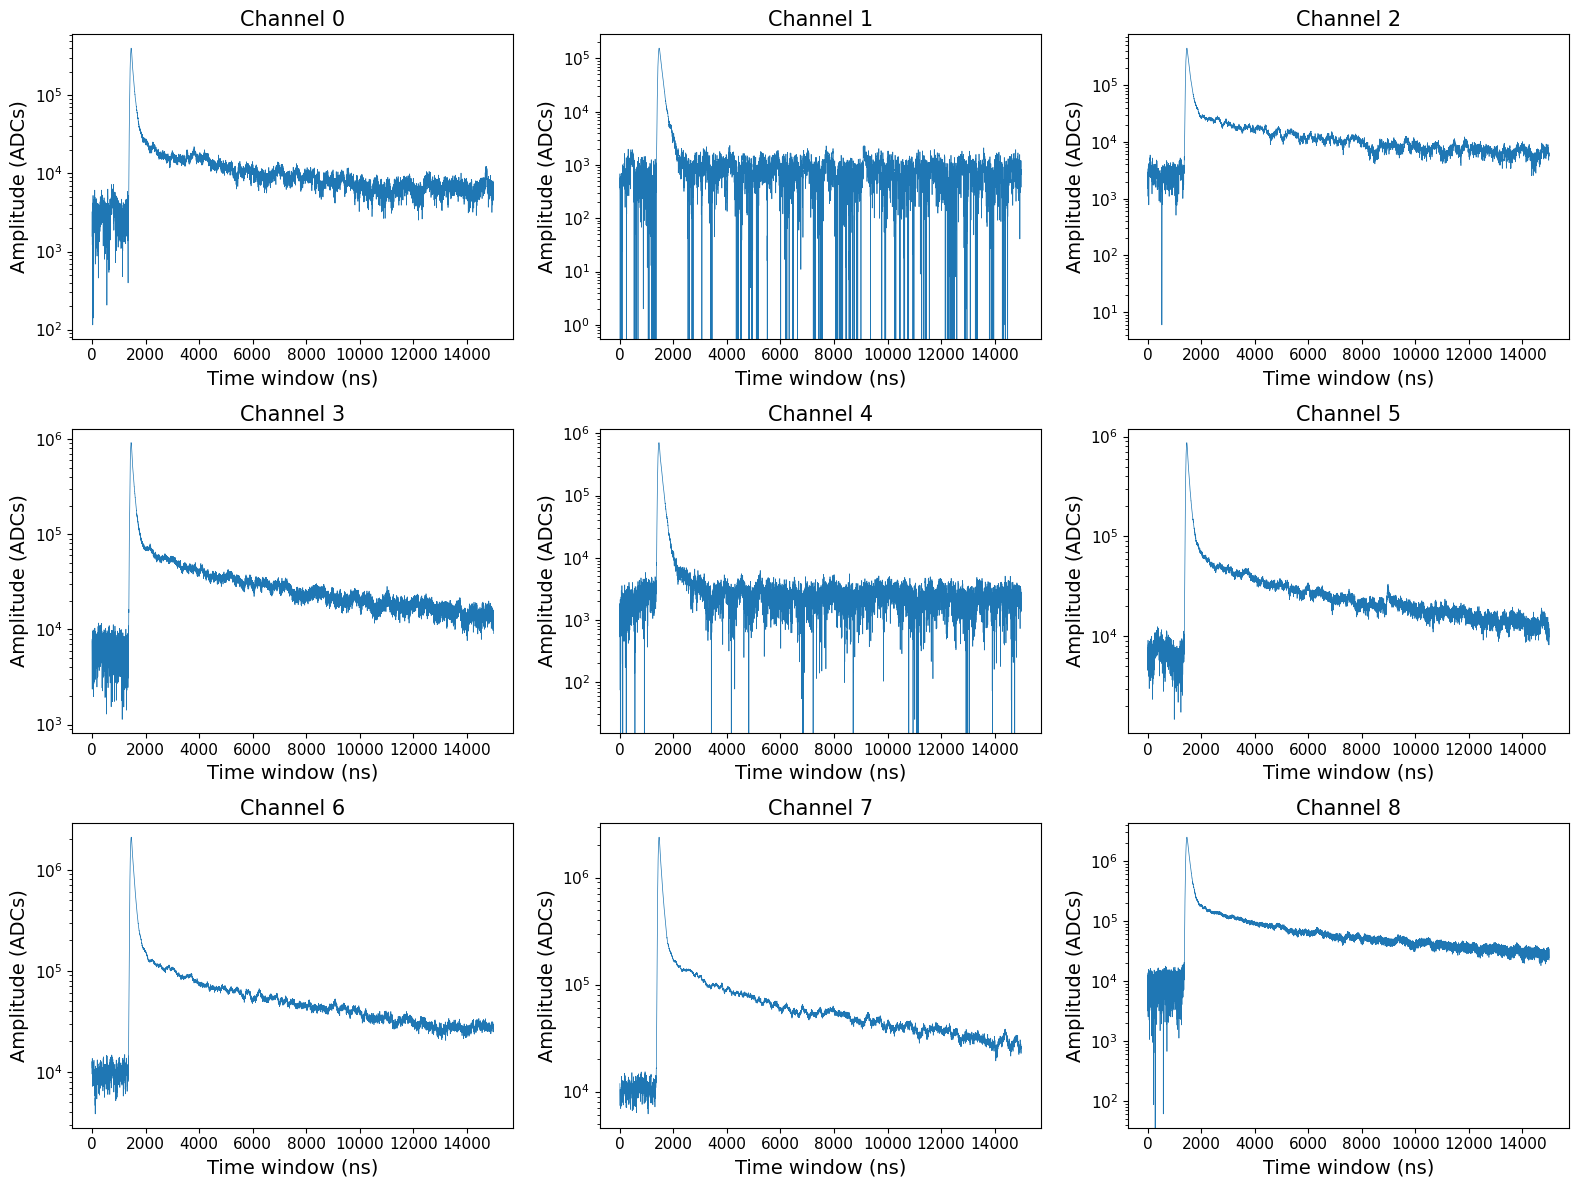

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    sum_wfs = summed_swfs_dict[k]
    axs[i][j].plot(2*np.arange(len(sum_wfs)), sum_wfs, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=14)
    axs[i][j].set_ylabel('Amplitude (ADCs)', fontsize=14)
    axs[i][j].set_title(f"Channel {k}", fontsize=15)
    #axs[i][j].set_ylim(1e2, 1e7)
    axs[i][j].set_yscale('log')
plt.tight_layout()
plt.show()

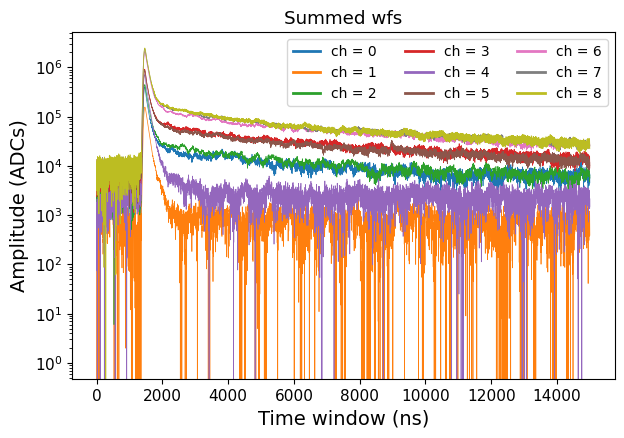

In [15]:
plt.figure(figsize=(7, 4.5))
for ch in range(9):
    sum_wfs = summed_swfs_dict[ch]
    plt.plot(2*np.arange(len(sum_wfs)), sum_wfs, linewidth=0.5, label=f'ch = {ch}')
    plt.title('Summed wfs')
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADCs)', fontsize=14)
    plt.yscale('log')
leg = plt.legend(ncol=3, fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Calibrate summed wfs with the gain of each SiPM

In [16]:
gains = [228.60604565191687, 206.34311805972095, 221.9751025687914, 215.06932276978736, 224.8076710540091,
         230.50097040107894, 226.52495525686777, 231.59231748969287, 225.42814952613816]

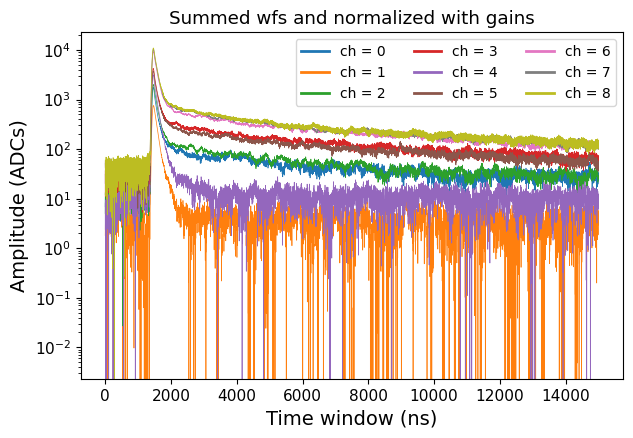

In [17]:
plt.figure(figsize=(7, 4.5))
for ch, gain in enumerate(gains):
    sum_wfs_cal = summed_swfs_dict[ch]/gain
    plt.plot(2*np.arange(len(sum_wfs_cal)), sum_wfs_cal, linewidth=0.5, label=f'ch = {ch}')
    plt.title('Summed wfs and normalized with gains')
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADCs)', fontsize=14)
    plt.yscale('log')
leg = plt.legend(ncol=3, fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Normalize also with the number of evts

In [18]:
summed_swfs_norm_dict = {ch: np.sum([wf[1] for wf in subt_wfs_dict[ch]], axis=0)/len(subt_wfs_dict[ch])
                         for ch in range(9)}

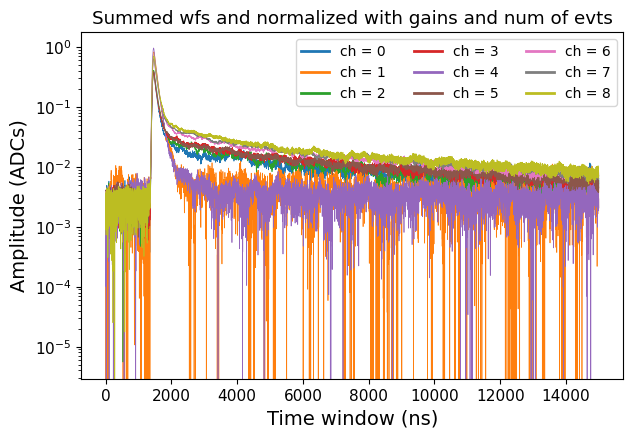

In [19]:
plt.figure(figsize=(7, 4.5))
for ch, gain in enumerate(gains):
    sum_wfs_norm_cal = summed_swfs_norm_dict[ch]/gain
    plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5, label=f'ch = {ch}')
    plt.title('Summed wfs and normalized with gains and num of evts')
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADCs)', fontsize=14)
    plt.yscale('log')
leg = plt.legend(ncol=3, fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Let's take the events for all SiPMs everytime a single one detects light

In [20]:
evts_filt_dict = {ch: np.array([evt for evt, wf in enumerate(wfs_from_rawtree(RawTree, ch)) if np.std(wf) > 15])
                  for ch in range(9)}
signal_evts = np.unique(np.concatenate(list(evts_filt_dict.values())))

In [21]:
partial_subtract_baseline = partial(pf.subtract_baseline, mode=True, wf_range_bsl=(0, max_smpl_bsl))
subt_all_wfs_dict = {ch: list(map(partial_subtract_baseline, wfs_from_rawtree(RawTree, ch)))
                     for ch in range(9)}

In [22]:
for vals in subt_all_wfs_dict.values():
    print(len(vals))

23655
23655
23655
23655
23655
23655
23655
23655
23655


In [23]:
subt_wfs_join_evts_dict = {ch: np.array([subt_all_wfs_dict[ch][evt] for evt in signal_evts])
                           for ch in range(9)}

In [24]:
len(np.sum(subt_wfs_join_evts_dict[0], axis=0))

7500

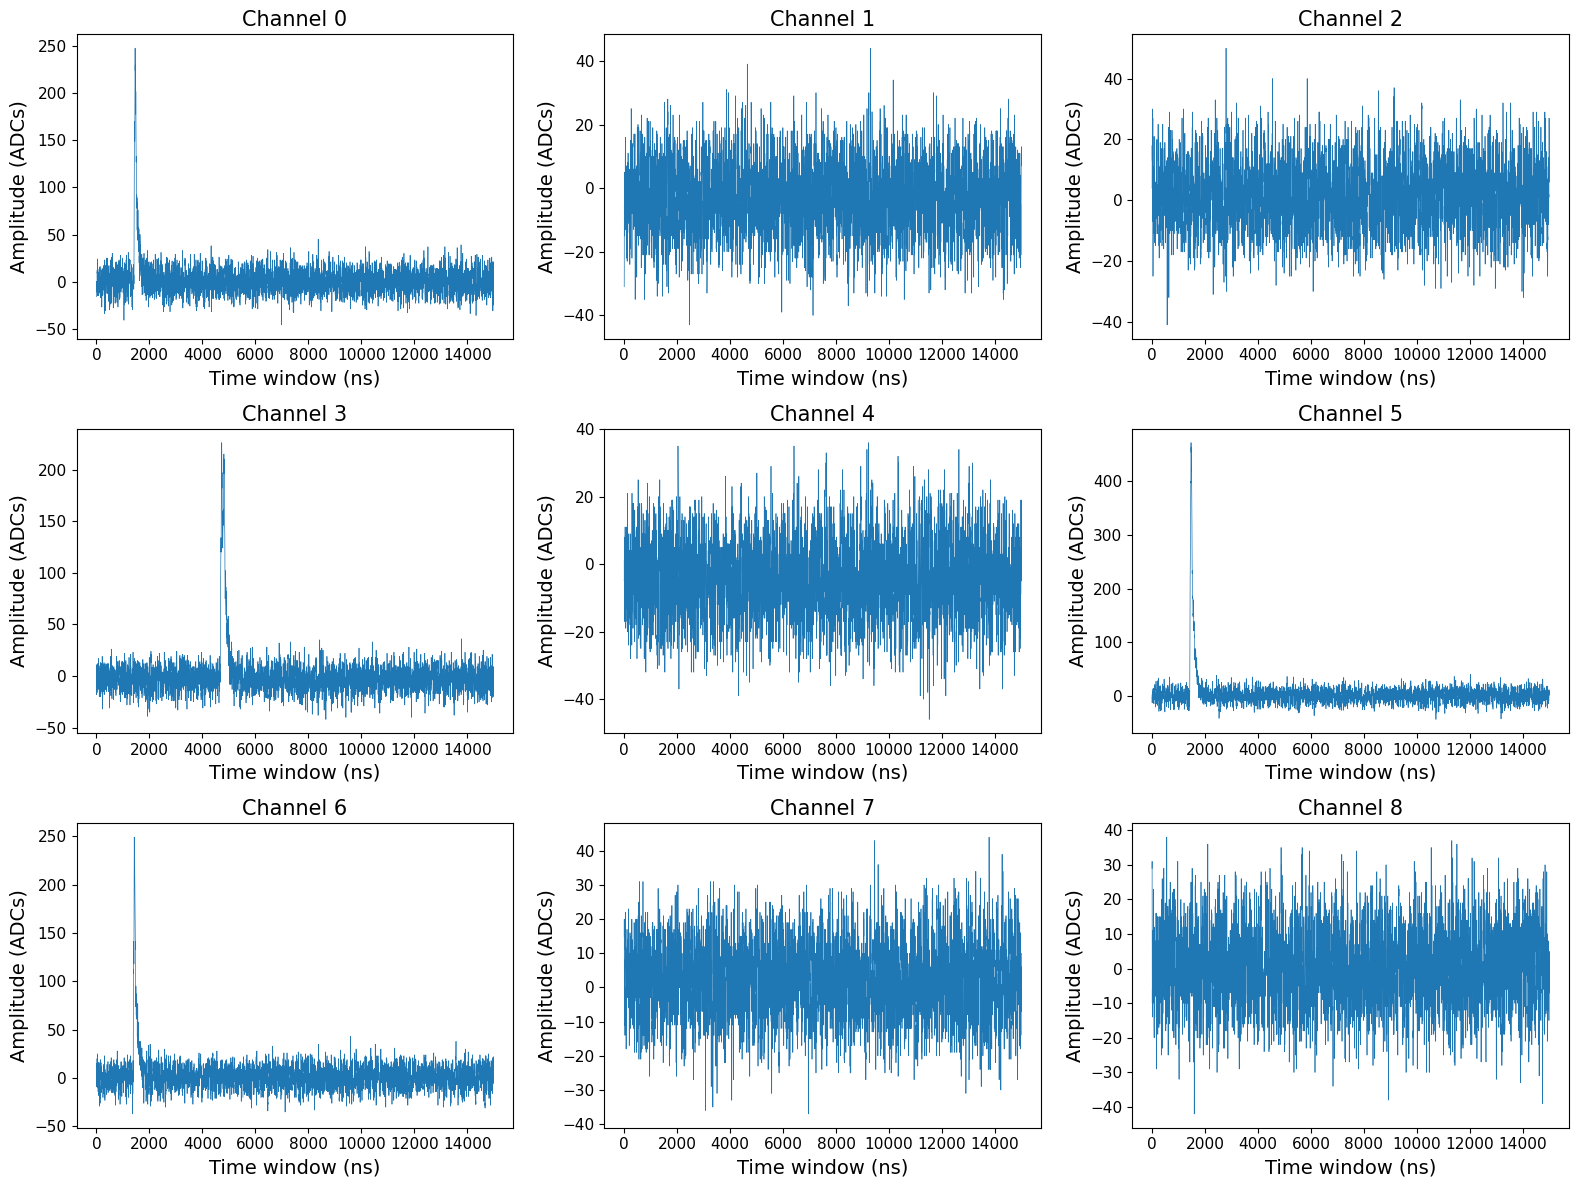

In [25]:
sel_evt  = 4
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    sel_wf = subt_wfs_join_evts_dict[k][sel_evt]
    axs[i][j].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=14)
    axs[i][j].set_ylabel('Amplitude (ADCs)', fontsize=14)
    axs[i][j].set_title(f"Channel {k}", fontsize=15)
    #axs[i][j].set_ylim(1e2, 1e7)
plt.tight_layout()
plt.show()

In [26]:
summed_swfs_norm_join_evts_dict = {ch: np.sum(subt_wfs_join_evts_dict[ch], axis=0)/len(subt_wfs_join_evts_dict[ch])
                                   for ch in range(9)}

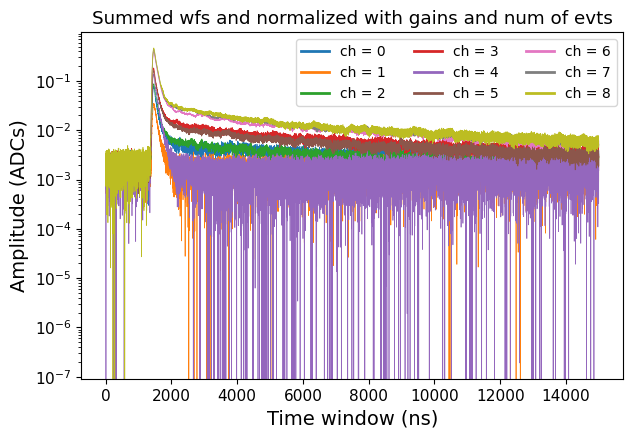

In [27]:
plt.figure(figsize=(7, 4.5))
for ch, gain in enumerate(gains):
    sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[ch]/gain
    plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5, label=f'ch = {ch}')
    plt.title('Summed wfs and normalized with gains and num of evts')
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADCs)', fontsize=14)
    plt.yscale('log')
leg = plt.legend(ncol=3, fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Apply the Savitzky-Golay filter

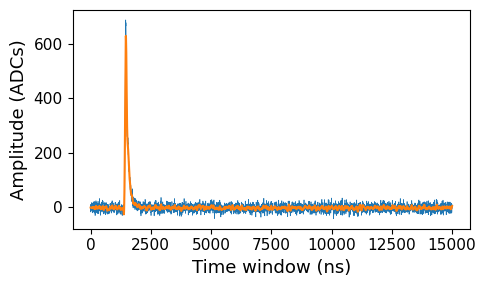

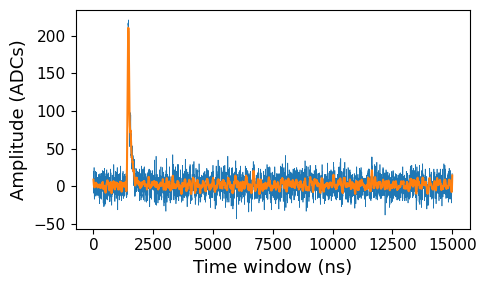

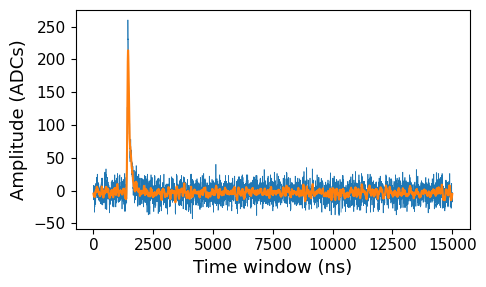

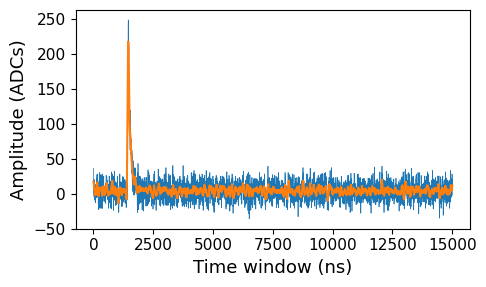

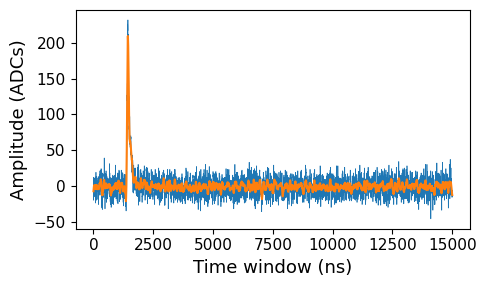

In [28]:
sel_ch = 4
for evt, swf in subt_wfs_dict[sel_ch][:5]:
    fswf = savgol_filter(swf, 50, 3)
    
    plt.figure(figsize=(5, 3))
    plt.plot(2*np.arange(len(swf)),  swf,  linewidth=0.5)
    plt.plot(2*np.arange(len(fswf)), fswf, linewidth=1.5)
    plt.xlabel('Time window (ns)', fontsize=13)
    plt.ylabel('Amplitude (ADCs)', fontsize=13)
    #plt.xlim(800, 2400)
    plt.tight_layout()
    plt.show()

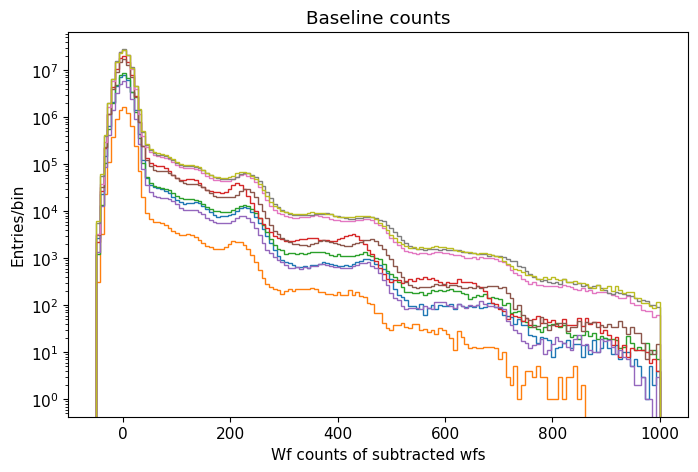

In [29]:
for ch in range(9):
    plt.hist(np.concatenate((subt_wfs_dict[ch].T[1:][0])), bins=150, log=True, histtype='step', range=(-50, 1000), label=f'ch = {ch}')
plt.xlabel('Wf counts of subtracted wfs')
plt.ylabel('Entries/bin')
plt.title('Baseline counts')
plt.show()

## Apply SG filter to all subtracted wfs

In [30]:
sg_filt_swfs_dict = {ch: np.array([(evt, savgol_filter(wf, 50, 3)) for evt, wf in subt_wfs_dict[ch]])
                     for ch in range(9)}

In [31]:
sg_filt_swfs_dict[0][0]

array([4,
       array([-15.939984  , -13.123873  , -10.538319  , ...,   0.11652736,
                3.0208166 ,   6.2916794 ], dtype=float32)                 ],
      dtype=object)

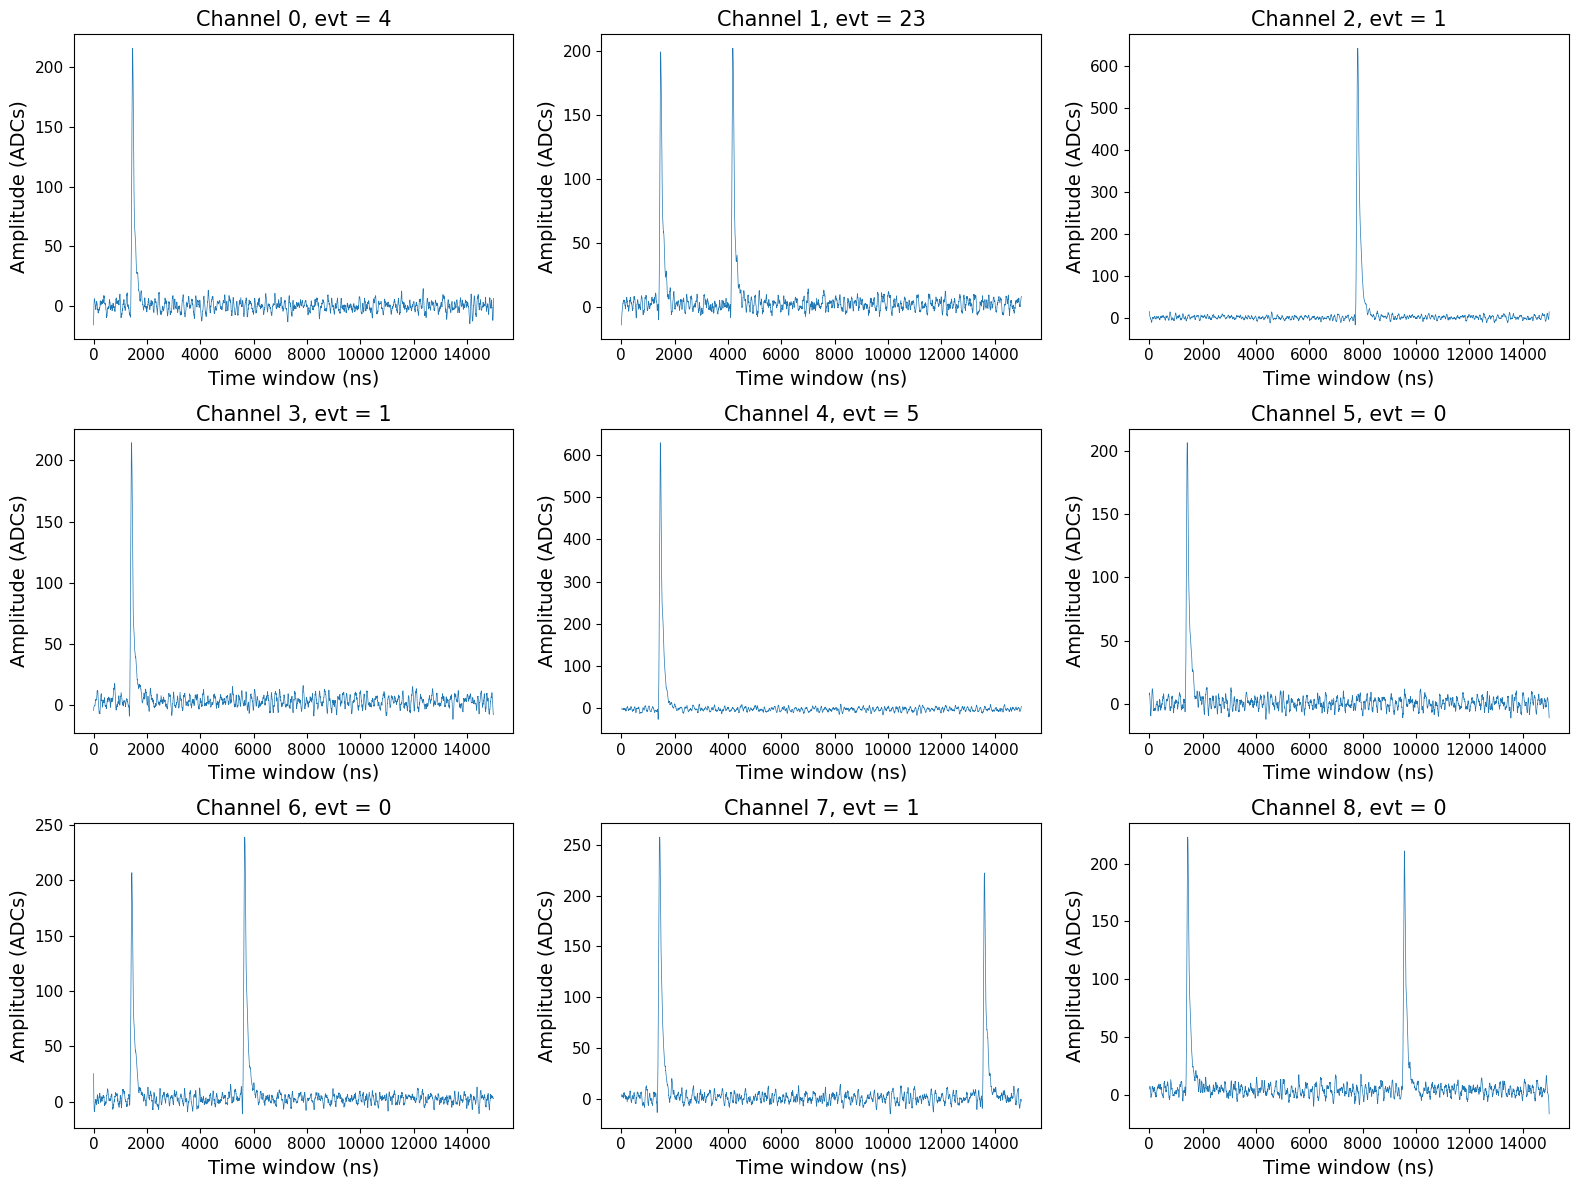

In [32]:
sel_idx  = 0
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    evt, sel_wf = sg_filt_swfs_dict[k][sel_idx]
    axs[i][j].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=14)
    axs[i][j].set_ylabel('Amplitude (ADCs)', fontsize=14)
    axs[i][j].set_title(f"Channel {k}, evt = {evt}", fontsize=15)
    #axs[i][j].set_ylim(1e2, 1e7)
plt.tight_layout()
plt.show()

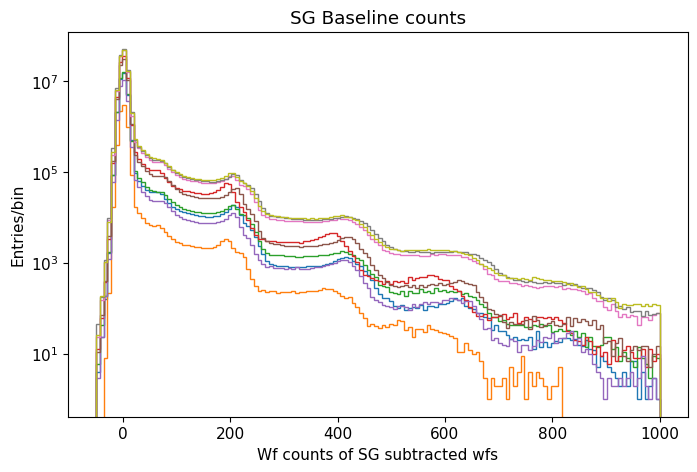

In [33]:
for ch in range(9):
    plt.hist(np.concatenate((sg_filt_swfs_dict[ch].T[1:][0])), bins=150, log=True, histtype='step', range=(-50, 1000), label=f'ch = {ch}')
plt.xlabel('Wf counts of SG subtracted wfs')
plt.ylabel('Entries/bin')
plt.title('SG Baseline counts')
plt.show()

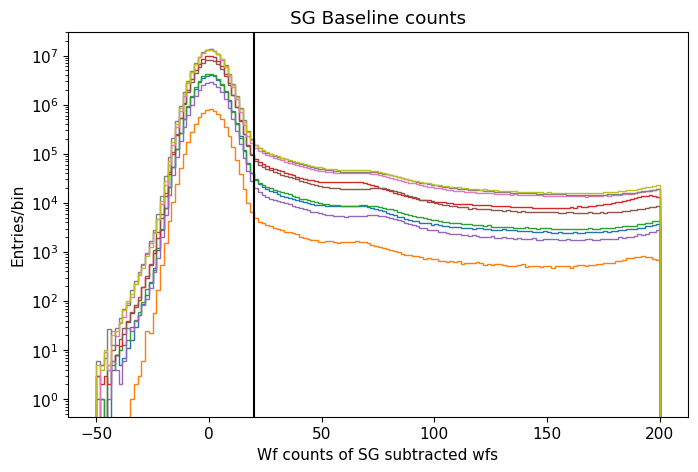

In [34]:
for ch in range(9):
    plt.hist(np.concatenate((sg_filt_swfs_dict[ch].T[1:][0])), bins=150, log=True, histtype='step', range=(-50, 200), label=f'ch = {ch}')
plt.axvline(x=20, color='k')
plt.xlabel('Wf counts of SG subtracted wfs')
plt.ylabel('Entries/bin')
plt.title('SG Baseline counts')
plt.show()

In [35]:
for ch in range(9):
    plt.hist(np.concatenate((sg_filt_swfs_dict[ch].T[1:][0])), bins=150, log=False, histtype='step', range=(-50, 200), label=f'ch = {ch}', density=True)
plt.axvline(x=20, color='k')
plt.xlabel('Wf counts of SG subtracted wfs, all channels normalized')
plt.ylabel('Entries/bin')
plt.title('SG Baseline counts')
plt.show()

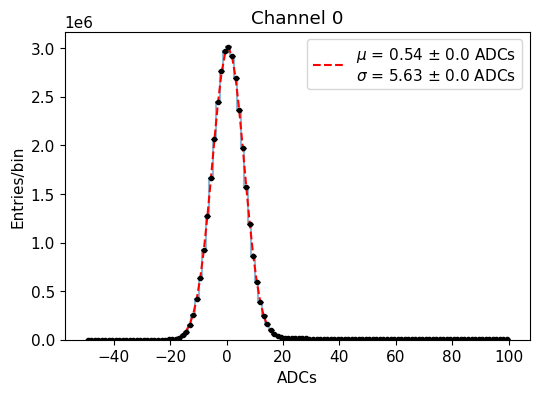

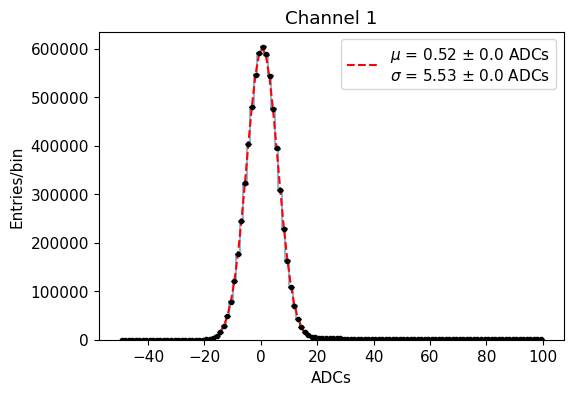

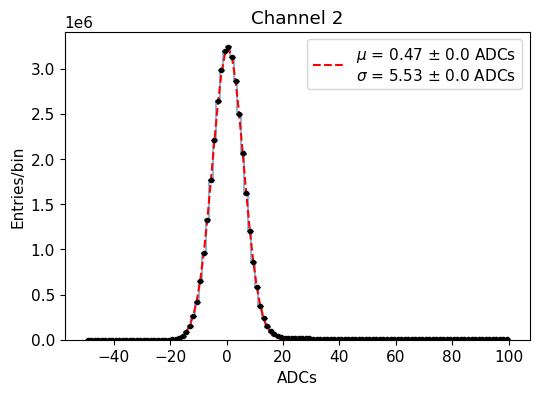

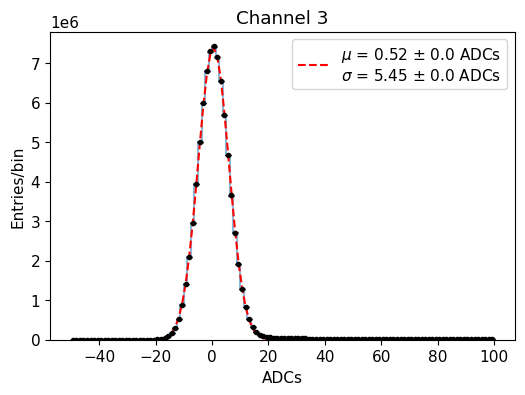

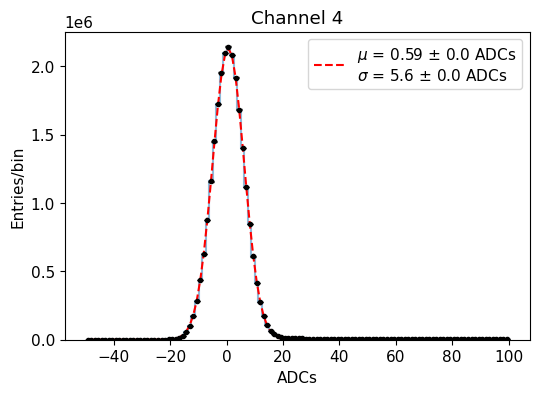

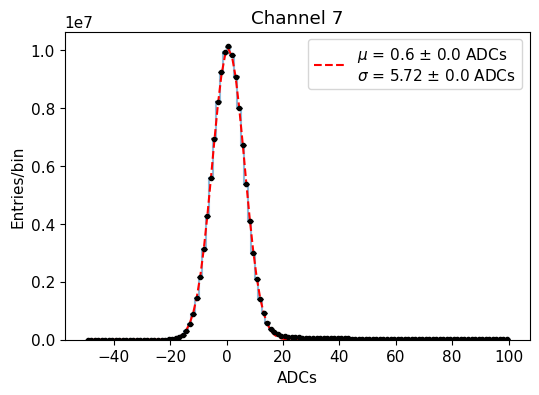

In [36]:
for ch in range(9):
    fitf.gaussian_fit_IC(np.concatenate((sg_filt_swfs_dict[ch].T[1:][0])), bins=120, prange=(-50, 100),
                         ampl=1000000, mean=0, sigma=10, frange=(-20, 20), title=f'Channel {ch}',
                         print_chi2=False, figsize=(6,4))

## Thr = 20 ADC to SG filtered wfs

In [37]:
sg_filt_swfs_dict

{0: array([[4,
         array([-15.939984  , -13.123873  , -10.538319  , ...,   0.11652736,
                  3.0208166 ,   6.2916794 ], dtype=float32)                 ],
        [12,
         array([ -6.0047607,  -6.1796813,  -6.3226705, ..., -17.437996 ,
                -18.068558 , -18.646267 ], dtype=float32)               ],
        [16,
         array([24.571386 , 19.413536 , 14.66583  , ...,  5.6965494,  8.888235 ,
                12.364678 ], dtype=float32)                                     ],
        ...,
        [23639,
         array([-10.082995,  -9.52658 ,  -8.992334, ..., -14.721284, -16.180586,
                -17.731062], dtype=float32)                                     ],
        [23640,
         array([-5.706193 , -5.69819  , -5.6430807, ...,  1.090904 ,  0.7992797,
                 0.5049774], dtype=float32)                                     ],
        [23647,
         array([ -6.4742494,  -5.3863196,  -4.416038 , ..., -31.157906 ,
                -35.693993 , 

In [38]:
thr_ADC = 20
sel_ch  = 0
sel_evt = 0

s_wf  = subt_wfs_dict    [sel_ch][sel_evt][1]
fs_wf = sg_filt_swfs_dict[sel_ch][sel_evt][1]

plt.figure(figsize=(6, 4))

plt.plot(2*np.arange(len(s_wf)),  s_wf,  linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fs_wf)), fs_wf, linewidth=1.5, label='filt swf')

points_above_thr_idx = np.where((s_wf>thr_ADC))[0]
points_above_thr_val = s_wf[points_above_thr_idx]

plt.scatter(2*points_above_thr_idx, points_above_thr_val, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Samples above {thr_ADC} pe')
plt.axhline(y=thr_ADC, color='green', linewidth=0.5)

plt.xlabel('Time window (ns)',     fontsize=13)
plt.ylabel('Amplitude (ADC)', fontsize=13)
plt.legend(fontsize=10)
plt.show()

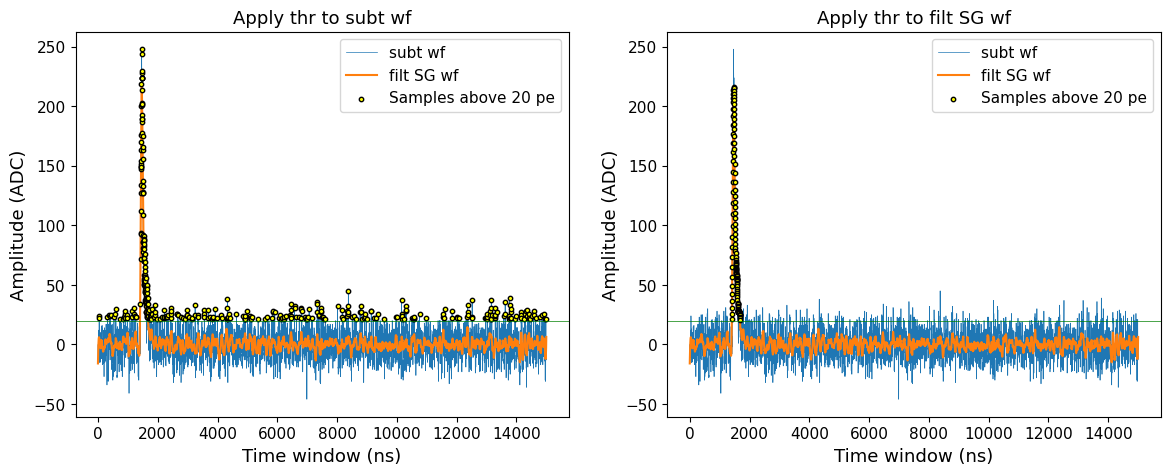

In [39]:
thr_ADC = 20
sel_ch  = 0
sel_evt = 0

s_wf  = subt_wfs_dict    [sel_ch][sel_evt][1]
fs_wf = sg_filt_swfs_dict[sel_ch][sel_evt][1]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

for ax, wf, wf_type in zip([ax0, ax1], [s_wf, fs_wf], ['subt', 'filt SG']):
    ax.plot(2*np.arange(len(s_wf)),  s_wf,  linewidth=0.5, label='subt wf')
    ax.plot(2*np.arange(len(fs_wf)), fs_wf, linewidth=1.5, label='filt SG wf')
    
    points_above_thr_idx = np.where((wf>thr_ADC))[0]
    points_above_thr_val = wf[points_above_thr_idx]

    ax.scatter(2*points_above_thr_idx, points_above_thr_val, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Samples above {thr_ADC} pe')
    ax.axhline(y=thr_ADC, color='green', linewidth=0.5)

    ax.set_xlabel('Time window (ns)',     fontsize=13)
    ax.set_ylabel('Amplitude (ADC)', fontsize=13)
    ax.set_title(f'Apply thr to {wf_type} wf',  fontsize=13)
    ax.legend(fontsize=11)
plt.show()

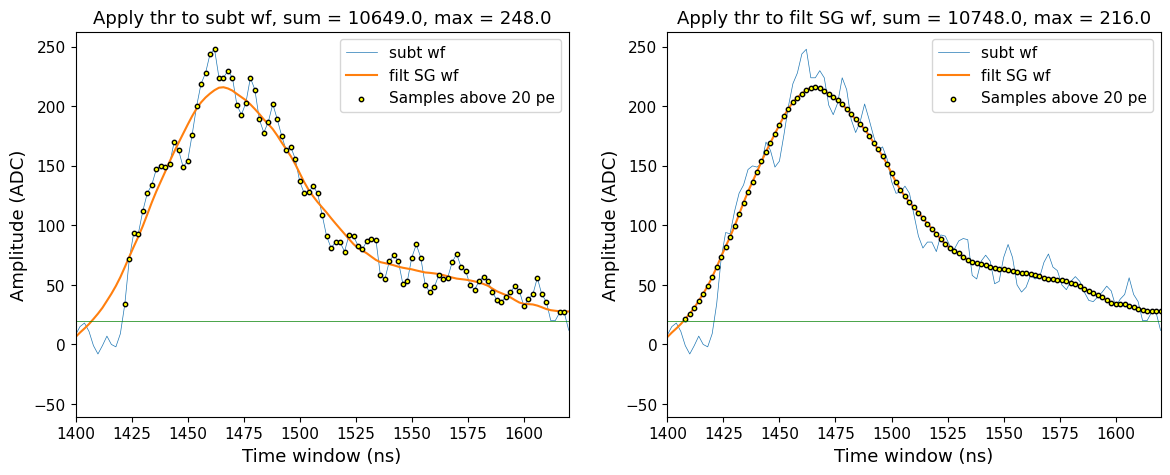

In [40]:
thr_ADC   = 20
sel_ch    = 0
sel_evt   = 0
wf_window = (1400, 1620)

s_wf  = subt_wfs_dict    [sel_ch][sel_evt][1]
fs_wf = sg_filt_swfs_dict[sel_ch][sel_evt][1]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

for ax, wf, wf_type in zip([ax0, ax1], [s_wf, fs_wf], ['subt', 'filt SG']):
    ax.plot(2*np.arange(len(s_wf)),  s_wf,  linewidth=0.5, label='subt wf')
    ax.plot(2*np.arange(len(fs_wf)), fs_wf, linewidth=1.5, label='filt SG wf')
    
    points_above_thr_idx = np.where((wf>thr_ADC))[0]
    points_above_thr_val = wf[points_above_thr_idx]
    sum_points = np.sum(points_above_thr_val[(points_above_thr_idx>wf_window[0]/2) & (points_above_thr_idx<wf_window[1]/2)])
    max_wf     = np.max(points_above_thr_val)

    ax.scatter(2*points_above_thr_idx, points_above_thr_val, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Samples above {thr_ADC} pe')
    ax.axhline(y=thr_ADC, color='green', linewidth=0.5)
    ax.set_xlim(wf_window)

    ax.set_xlabel('Time window (ns)',     fontsize=13)
    ax.set_ylabel('Amplitude (ADC)', fontsize=13)
    ax.set_title(f'Apply thr to {wf_type} wf, sum = {np.round(sum_points)}, max = {np.round(max_wf)}',  fontsize=13)
    ax.legend(fontsize=11)
plt.show()

In [41]:
thr_ADC = 20
sel_ch  = 0
sel_evt = 0

s_wf  = subt_wfs_dict    [sel_ch][sel_evt][1]
fs_wf = sg_filt_swfs_dict[sel_ch][sel_evt][1]

plt.figure(figsize=(8, 5))

plt.plot(2*np.arange(len(s_wf)),  s_wf,  linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fs_wf)), fs_wf, linewidth=1.5, label='filt swf')

points_above_thr_idx = np.where((fs_wf>thr_ADC))[0]
points_above_thr_val = fs_wf[points_above_thr_idx]

plt.scatter(2*points_above_thr_idx, points_above_thr_val, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Samples above {thr_ADC} pe')
plt.axhline(y=thr_ADC, color='green', linewidth=0.5)

plt.xlabel('Time window (ns)',     fontsize=13)
plt.ylabel('Amplitude (ADC)', fontsize=13)
plt.legend(fontsize=10)
plt.show()

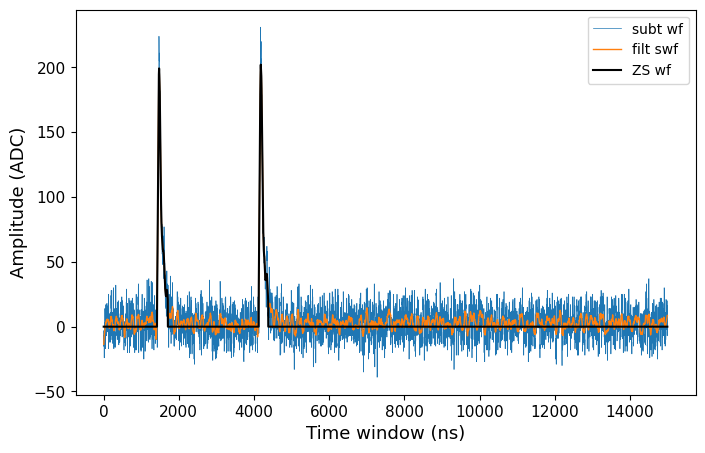

In [42]:
thr_ADC = 20
sel_ch  = 1
sel_evt = 0

s_wf  = subt_wfs_dict    [sel_ch][sel_evt][1]
fs_wf = sg_filt_swfs_dict[sel_ch][sel_evt][1]
zs_wf = pf.noise_suppression(fs_wf, threshold=thr_ADC)

plt.figure(figsize=(8, 5))

plt.plot(2*np.arange(len(s_wf)),  s_wf,  linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fs_wf)), fs_wf, linewidth=1,   label='filt swf')
plt.plot(2*np.arange(len(zs_wf)), zs_wf, linewidth=1.5, label='ZS wf', color='k')

plt.xlabel('Time window (ns)',     fontsize=13)
plt.ylabel('Amplitude (ADC)', fontsize=13)
plt.legend(fontsize=10)
plt.show()

In [43]:
peaks_idx       = pf.get_peaks_peakutils(zs_wf)
peak_heights_zs = pf.peak_height(zs_wf, peaks_idx)
peak_heights_s  = pf.peak_height(s_wf,  peaks_idx)

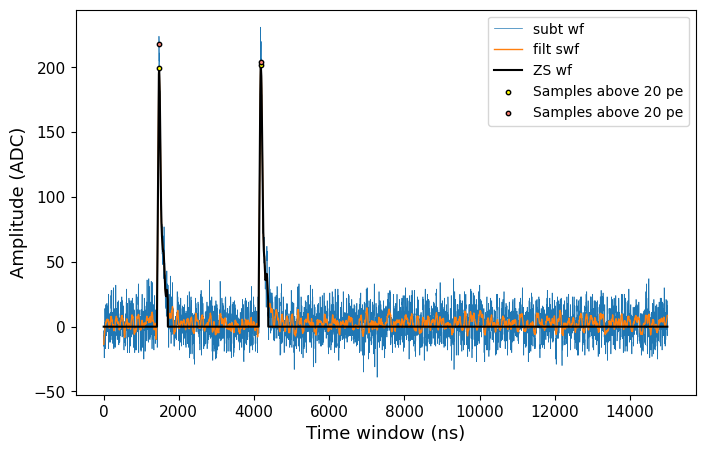

In [44]:
thr_ADC = 20
sel_ch  = 1
sel_evt = 0

s_wf  = subt_wfs_dict    [sel_ch][sel_evt][1]
fs_wf = sg_filt_swfs_dict[sel_ch][sel_evt][1]
zs_wf = pf.noise_suppression(fs_wf, threshold=thr_ADC)

plt.figure(figsize=(8, 5))

plt.plot(2*np.arange(len(s_wf)),  s_wf,  linewidth=0.5, label='subt wf')
plt.plot(2*np.arange(len(fs_wf)), fs_wf, linewidth=1,   label='filt swf')
plt.plot(2*np.arange(len(zs_wf)), zs_wf, linewidth=1.5, label='ZS wf', color='k')

plt.scatter(2*peaks_idx, peak_heights_zs, color='yellow', edgecolors='black', marker='o', s=10, zorder=2, label=f'Samples above {thr_ADC} pe')
plt.scatter(2*peaks_idx, peak_heights_s , color='salmon', edgecolors='black', marker='o', s=10, zorder=2, label=f'Samples above {thr_ADC} pe')

plt.xlabel('Time window (ns)',     fontsize=13)
plt.ylabel('Amplitude (ADC)', fontsize=13)
plt.legend(fontsize=10)
plt.show()

## Save peaks and times for all channels using the filtered SG wf:

In [45]:
partial_noise_suppression = partial(pf.noise_suppression, threshold=thr_ADC)

zs_sg_filt_swfs_dict = {ch: np.array(list(map(partial_noise_suppression, sg_filt_swfs_dict[ch].T[1:])))[0]
                        for ch in range(9)}

idx_peaks_ch_dict = {ch: np.array(list(map(pf.get_peaks_peakutils, zs_sg_filt_swfs_dict[ch])))
                     for ch in range(9)}

height_peaks_ch_dict = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_dict[ch][i]) for i,wf in enumerate(zs_sg_filt_swfs_dict[ch])])
                        for ch in range(9)}

In [46]:
filt_evts_dict = {ch: filt_wfs_dict[ch].T[0] for ch in range(9)}

In [47]:
for ch in range(9):
    print(len(sg_filt_swfs_dict[ch]), len(zs_sg_filt_swfs_dict[ch]), len(idx_peaks_ch_dict[ch]), len(height_peaks_ch_dict[ch]))

4626 4626 4626 4626
908 908 908 908
4883 4883 4883 4883
11053 11053 11053 11053
3261 3261 3261 3261
9549 9549 9549 9549
15232 15232 15232 15232
15972 15972 15972 15972
15397 15397 15397 15397


In [48]:
## Same analysis but without saving the evt number

test = {ch: np.array([pf.subtract_baseline(fwf,
                                    mode=True,
                                    wf_range_bsl=(0, max_smpl_bsl))
                                    for _, fwf in filt_wfs_dict[ch]])
                 for ch in range(9)}

test2 = {ch: savgol_filter(test[ch],
                   window_length=50,
                   polyorder=3)
            for ch in range(9)}

test3 = {ch: pf.noise_suppression(test2[ch],
                                  threshold=thr_ADC)
                        for ch in range(9)}

In [49]:
for ch in range(9):
    print(test[ch].shape, test2[ch].shape, test3[ch].shape)

(4626, 7500) (4626, 7500) (4626, 7500)
(908, 7500) (908, 7500) (908, 7500)
(4883, 7500) (4883, 7500) (4883, 7500)
(11053, 7500) (11053, 7500) (11053, 7500)
(3261, 7500) (3261, 7500) (3261, 7500)
(9549, 7500) (9549, 7500) (9549, 7500)
(15232, 7500) (15232, 7500) (15232, 7500)
(15972, 7500) (15972, 7500) (15972, 7500)
(15397, 7500) (15397, 7500) (15397, 7500)


## Plot hits vs time for one channel:

In [50]:
sel_ch = 0
plt.scatter(np.concatenate((idx_peaks_ch_dict[sel_ch])), np.concatenate((height_peaks_ch_dict[sel_ch])), s=0.2)
plt.ylim(0, 1800)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.show()

In [51]:
plt.hist2d(np.concatenate((idx_peaks_ch_dict[sel_ch])), np.concatenate((height_peaks_ch_dict[sel_ch])), bins=(750, 150), range=((0, 7500), (0, 1500)), cmin=1)
plt.xlabel('Time window (ns)',      fontsize=13)
plt.ylabel('Amplitude peaks (ADC)', fontsize=13)
plt.show()

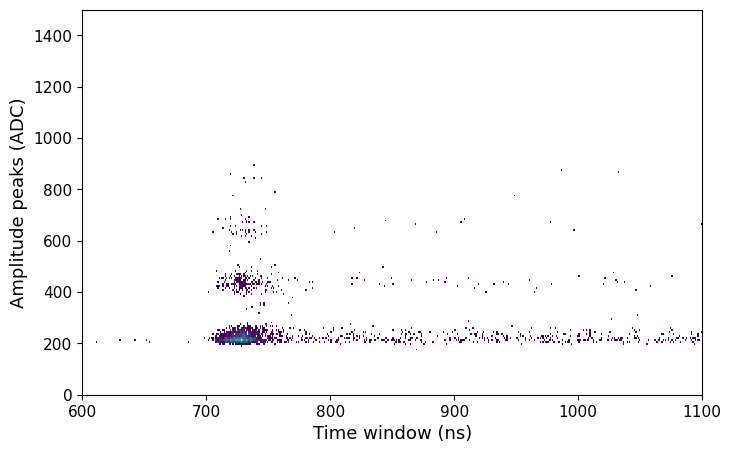

In [52]:
plt.hist2d(np.concatenate((idx_peaks_ch_dict[sel_ch])), np.concatenate((height_peaks_ch_dict[sel_ch])), bins=(500, 200), range=((600, 1100), (0, 1500)), cmin=1)
plt.xlabel('Time window (ns)',      fontsize=13)
plt.ylabel('Amplitude peaks (ADC)', fontsize=13)
plt.show()

## Plot hits vs time for all channels

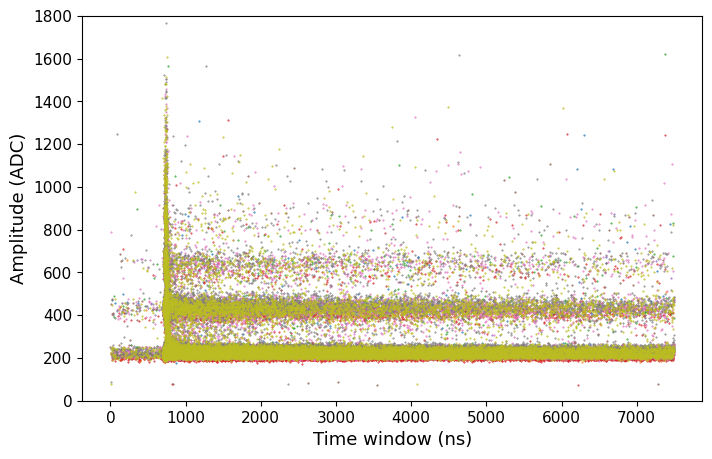

In [53]:
for ch in range(9):
    plt.scatter(np.concatenate((idx_peaks_ch_dict[ch])), np.concatenate((height_peaks_ch_dict[ch])), s=0.2)
plt.ylim(0, 1800)
plt.xlabel('Time window (ns)', fontsize=13)
plt.ylabel('Amplitude (ADC)',  fontsize=13)
plt.show()

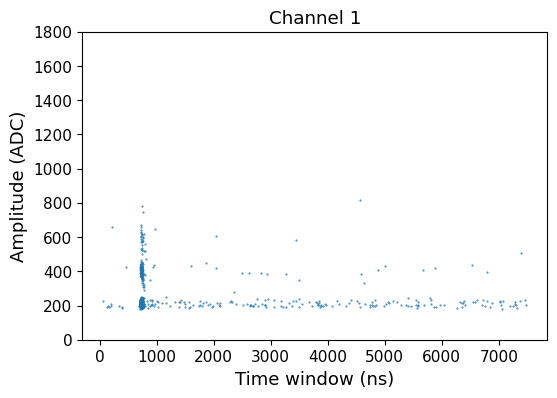

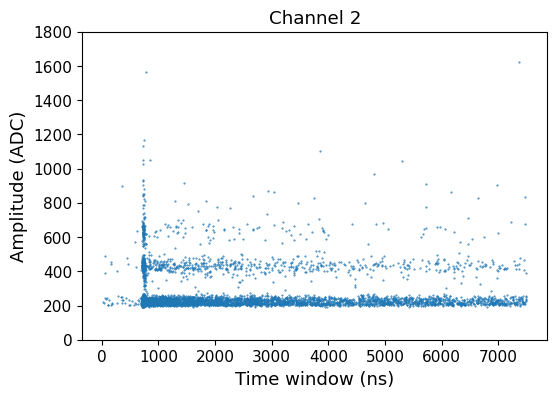

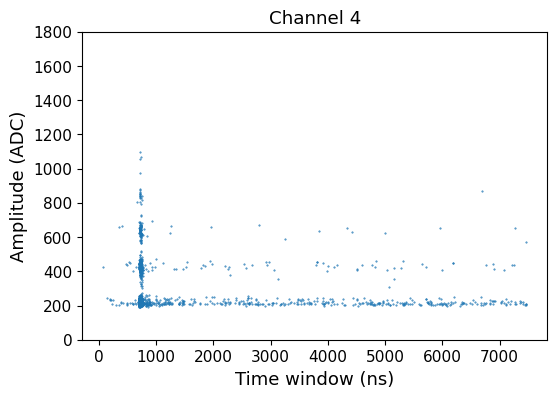

In [54]:
for ch in range(9):
    plt.figure(figsize=(6, 4))
    plt.scatter(np.concatenate((idx_peaks_ch_dict[ch])), np.concatenate((height_peaks_ch_dict[ch])), s=0.2)
    plt.ylim(0, 1800)
    plt.title(f'Channel {ch}')
    plt.xlabel('Time window (ns)', fontsize=13)
    plt.ylabel('Amplitude (ADC)',  fontsize=13)
    plt.show()

## Same analysis for the trigger SiPMs

In [55]:
trigger_chs     = [9, 10, 11]

## In the deconvolution the baseline is already subtracted from the waveform!!!
trigg_cwfs_dict = {ch: np.array([blr.pmt_deconvolver(wf, wf_range_bsl=(0, max_smpl_bsl))
                                 for wf in pf.wfs_from_rawtree(RawTree, ch)])
                                 for ch in trigger_chs}

In [56]:
### %%time
### subt_wfs_trigg_dict = {ch: pf.subtract_baseline(trigg_cwfs_dict[ch], mode=True, wf_range_bsl=(0, max_smpl_bsl))
###                        for ch in trigger_chs}

In [57]:
### %%time
### 
### ## Speed test
### subt_all_wfs_trigg_dict = {ch: np.array(list(map(partial_subtract_baseline, trigg_cwfs_dict[ch])))
###                            for ch in trigger_chs}

In [58]:
%%time
sg_filt_trigg_dict = {ch: savgol_filter(trigg_cwfs_dict[ch], window_length=50, polyorder=3)
                      for ch in trigger_chs}

CPU times: user 16.6 s, sys: 5.39 s, total: 22 s
Wall time: 15.1 s


In [59]:
zs_sg_filt_trigg_dict = {ch: pf.noise_suppression(sg_filt_trigg_dict[ch], threshold=thr_ADC)
                         for ch in trigger_chs}

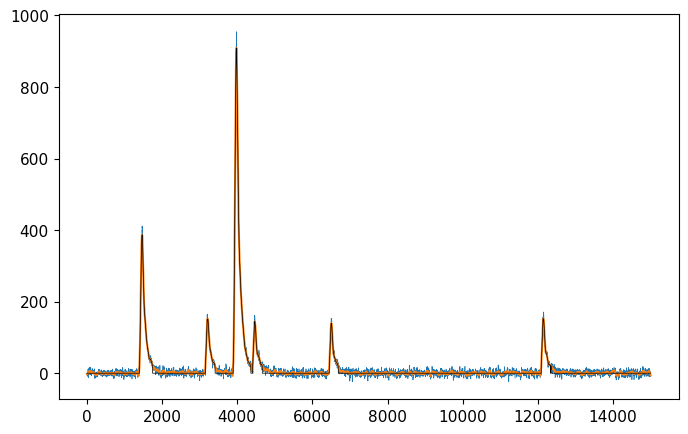

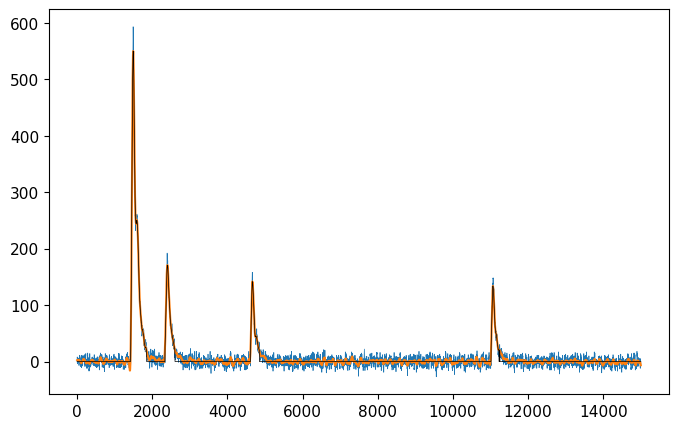

In [60]:
for evt in range(3):
    for ch in trigger_chs[1:2]:
        plt.plot(2*np.arange(len(trigg_cwfs_dict      [ch][evt])), trigg_cwfs_dict      [ch][evt], label=f'ch = {ch}', linewidth=0.5)
        plt.plot(2*np.arange(len(sg_filt_trigg_dict   [ch][evt])), sg_filt_trigg_dict   [ch][evt], label=f'ch = {ch}')
        plt.plot(2*np.arange(len(zs_sg_filt_trigg_dict[ch][evt])), zs_sg_filt_trigg_dict[ch][evt], label=f'ch = {ch}', color='k', linewidth=0.5)
    plt.show()

In [61]:
idx_peaks_ch_trigg_dict = {ch: np.array(list(map(pf.get_peaks_peakutils, zs_sg_filt_trigg_dict[ch])))
                           for ch in trigger_chs}

height_peaks_ch_trigg_dict = {ch: np.array([pf.peak_height(wf, idx_peaks_ch_trigg_dict[ch][i]) for i,wf in enumerate(zs_sg_filt_trigg_dict[ch])])
                              for ch in trigger_chs}

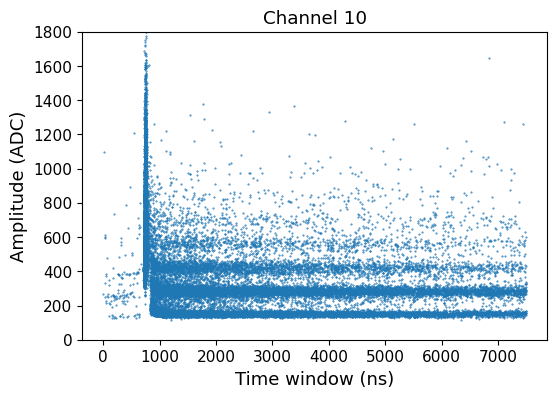

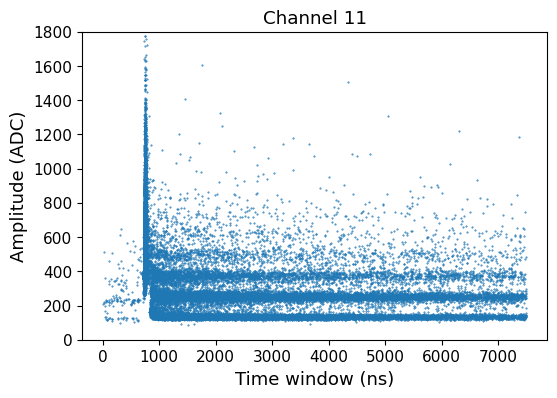

In [62]:
for ch in trigger_chs:
    plt.figure(figsize=(6, 4))
    plt.scatter(np.concatenate((idx_peaks_ch_trigg_dict[ch])), np.concatenate((height_peaks_ch_trigg_dict[ch])), s=0.2)
    plt.ylim(0, 1800)
    plt.title(f'Channel {ch}')
    plt.xlabel('Time window (ns)', fontsize=13)
    plt.ylabel('Amplitude (ADC)',  fontsize=13)
    plt.show()

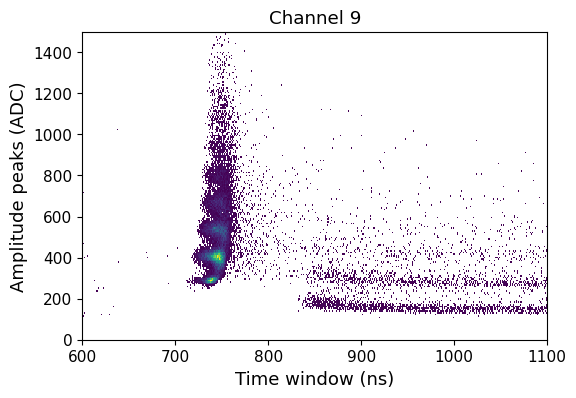

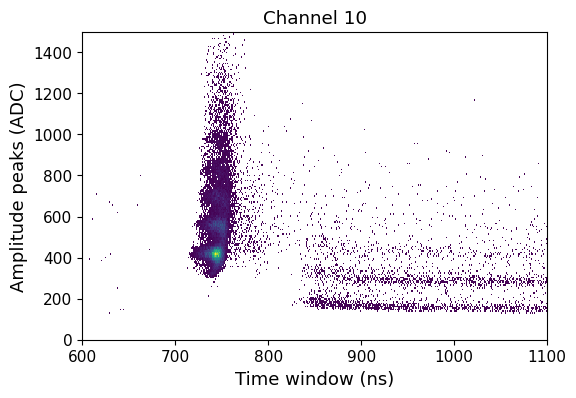

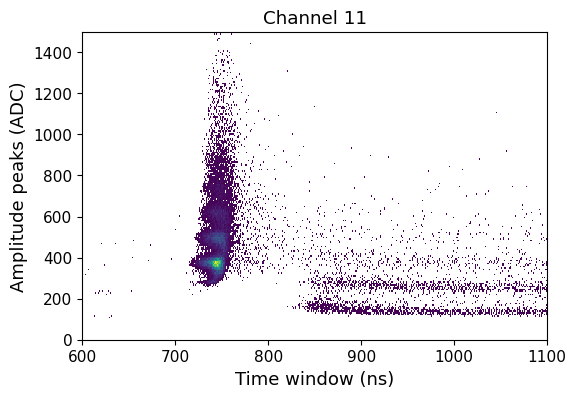

In [63]:
for ch in trigger_chs:
    plt.figure(figsize=(6, 4))
    plt.hist2d(np.concatenate((idx_peaks_ch_trigg_dict[ch])), np.concatenate((height_peaks_ch_trigg_dict[ch])), bins=(500, 200), range=((600, 1100), (0, 1500)), cmin=1)
    plt.title(f'Channel {ch}')
    plt.xlabel('Time window (ns)',      fontsize=13)
    plt.ylabel('Amplitude peaks (ADC)', fontsize=13)
    plt.show()

## Analyze nps file:

In [66]:
filename = '/Users/romoluque_c/LEGEND/BACON/data_npz/BACoN_hits_and_times_run-11_20_2023-file_1_test.npz'
d        = np.load(filename, allow_pickle=True)

# Access dictionaries using keys
filt_evts_dict_test             = d['filt_evts_dict']            .item()
idx_peaks_ch_dict_test          = d['idx_peaks_ch_dict']         .item()
height_peaks_ch_dict_test       = d['height_peaks_ch_dict']      .item()
idx_peaks_ch_trigg_dict_test    = d['idx_peaks_ch_trigg_dict']   .item()
height_peaks_ch_trigg_dict_test = d['height_peaks_ch_trigg_dict'].item()

In [68]:
filt_evts_dict_test;

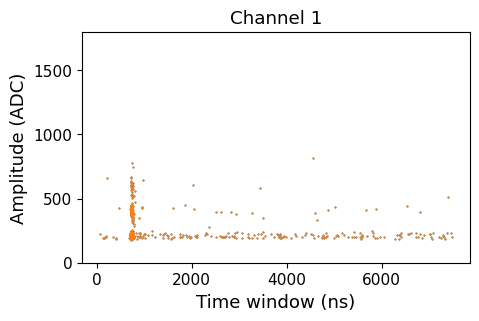

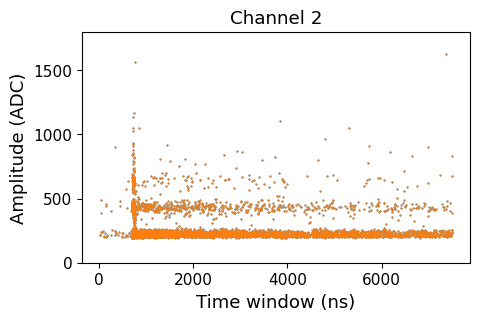

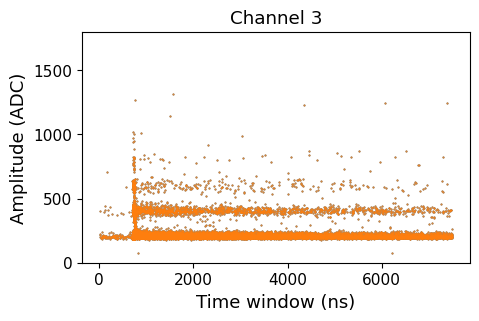

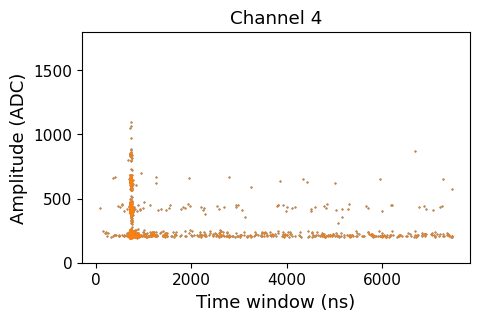

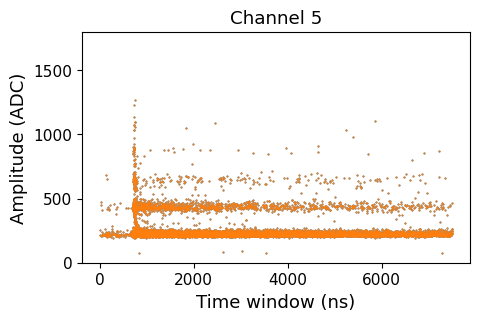

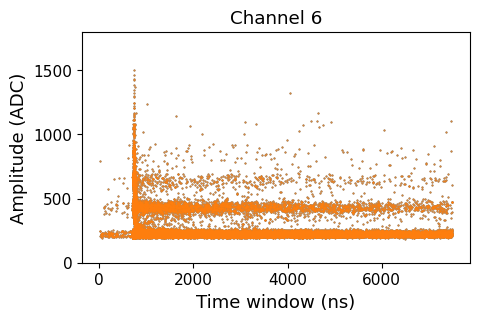

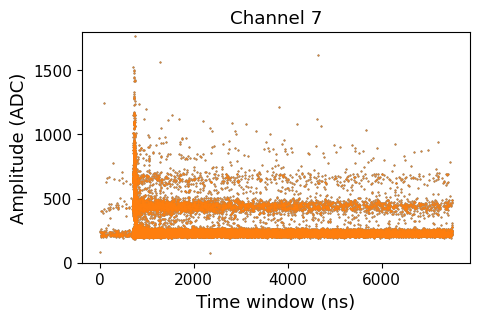

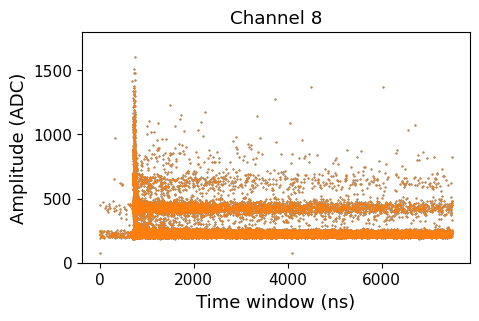

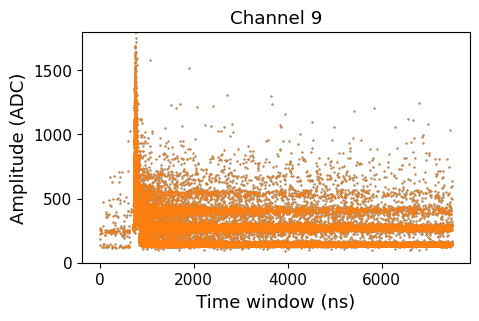

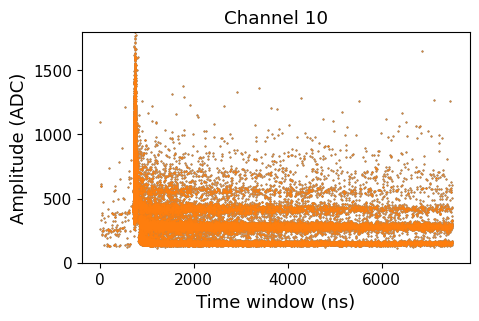

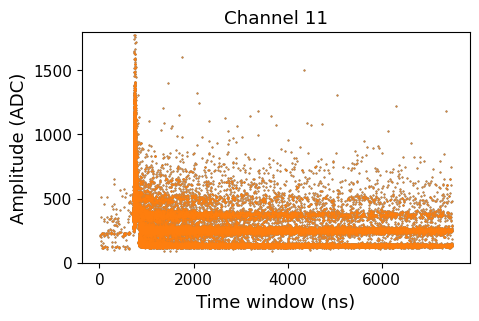

In [70]:
for ch in range(9):
    plt.figure(figsize=(5, 3))
    plt.scatter(np.concatenate((idx_peaks_ch_dict     [ch])), np.concatenate((height_peaks_ch_dict     [ch])), s=0.2)
    plt.scatter(np.concatenate((idx_peaks_ch_dict_test[ch])), np.concatenate((height_peaks_ch_dict_test[ch])), s=0.2)
    plt.ylim(0, 1800)
    plt.title(f'Channel {ch}')
    plt.xlabel('Time window (ns)', fontsize=13)
    plt.ylabel('Amplitude (ADC)',  fontsize=13)
    plt.show()
    
for ch in trigger_chs:
    plt.figure(figsize=(5, 3))
    plt.scatter(np.concatenate((idx_peaks_ch_trigg_dict     [ch])), np.concatenate((height_peaks_ch_trigg_dict     [ch])), s=0.2)
    plt.scatter(np.concatenate((idx_peaks_ch_trigg_dict_test[ch])), np.concatenate((height_peaks_ch_trigg_dict_test[ch])), s=0.2)
    plt.ylim(0, 1800)
    plt.title(f'Channel {ch}')
    plt.xlabel('Time window (ns)', fontsize=13)
    plt.ylabel('Amplitude (ADC)',  fontsize=13)
    plt.show()